<a href="https://colab.research.google.com/github/sahithinamala/Eclipse_codes/blob/main/du_unet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
from collections import OrderedDict

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=4):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )


In [12]:
from torchvision.transforms import Resize,Compose,InterpolationMode,ToTensor
tr = Compose([Resize((512,512),InterpolationMode.BILINEAR),ToTensor()])
tr

Compose(
    Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)

In [13]:
!ls

drive  sample_data


In [14]:
import glob
from PIL import Image
from torchvision.transforms.functional import to_tensor

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class HairDataset(Dataset):

    def __init__(self, root_dir, transform=tr):
        
        self.root_dir = root_dir
        self.transform = transform
        self.data = glob.glob(root_dir)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        m = self.data[idx]
        num = int(m.split('/')[-1].split('_')[0])
        img_name =  '/content/drive/MyDrive/train_data/CelebAMask-HQ/CelebA-HQ-img/'+str(num)+'.jpg'
        # img_name = m.replace('masked','')

        image = Image.open(img_name)
        mask = Image.open(m)
        sample = image,mask
        if self.transform:
            sample = self.transform(sample[0]),self.transform(sample[1])

        return sample

In [15]:
# train_folder_path = '/content/drive/MyDrive/train_tiff/'
train_folder_path = '/content/drive/MyDrive/train_data/CelebAMask*/CelebAMask-HQ-mask-anno/*/*_hair.png'
dataset = HairDataset(train_folder_path)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

In [16]:
for d in dataloader:
  print(d[0].shape,d[1].shape)
  break

torch.Size([8, 3, 512, 512]) torch.Size([8, 3, 512, 512])


In [17]:
import torch 
import numpy as np
model = UNet().cuda()
criteria = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([8, 1, 512, 512])) that is different to the input size (torch.Size([8, 3, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0  Batch: 0 Batch_Loss 0.24110960960388184
Epoch: 0  Batch: 1 Batch_Loss 0.22771906852722168
Epoch: 0  Batch: 2 Batch_Loss 0.22661952674388885
Epoch: 0  Batch: 3 Batch_Loss 0.21276652812957764
Epoch: 0  Batch: 4 Batch_Loss 0.22600118815898895
Epoch: 0  Batch: 5 Batch_Loss 0.20563159883022308
Epoch: 0  Batch: 6 Batch_Loss 0.20734429359436035
Epoch: 0  Batch: 7 Batch_Loss 0.21206514537334442
Epoch: 0  Batch: 8 Batch_Loss 0.22996996343135834
Epoch: 0  Batch: 9 Batch_Loss 0.20744502544403076
Epoch: 0  Batch: 10 Batch_Loss 0.21743232011795044
Epoch: 0  Batch: 11 Batch_Loss 0.19851762056350708
Epoch: 0  Batch: 12 Batch_Loss 0.2135298252105713
Epoch: 0  Batch: 13 Batch_Loss 0.20374071598052979
Epoch: 0  Batch: 14 Batch_Loss 0.2133590430021286
Epoch: 0  Batch: 15 Batch_Loss 0.20809295773506165
Epoch: 0  Batch: 16 Batch_Loss 0.22280701994895935
Epoch: 0  Batch: 17 Batch_Loss 0.19772374629974365
Epoch: 0  Batch: 18 Batch_Loss 0.19915637373924255
Epoch: 0  Batch: 19 Batch_Loss 0.2168639600

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([2, 1, 512, 512])) that is different to the input size (torch.Size([2, 3, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Batch: 0 Batch_Loss 0.05207234248518944
Epoch: 1  Batch: 1 Batch_Loss 0.06883896887302399
Epoch: 1  Batch: 2 Batch_Loss 0.062473516911268234
Epoch: 1  Batch: 3 Batch_Loss 0.06502343714237213
Epoch: 1  Batch: 4 Batch_Loss 0.08840860426425934
Epoch: 1  Batch: 5 Batch_Loss 0.05317407473921776
Epoch: 1  Batch: 6 Batch_Loss 0.04318932816386223
Epoch: 1  Batch: 7 Batch_Loss 0.04282744973897934
Epoch: 1  Batch: 8 Batch_Loss 0.07043522596359253
Epoch: 1  Batch: 9 Batch_Loss 0.051065996289253235
Epoch: 1  Batch: 10 Batch_Loss 0.04785914346575737
Epoch: 1  Batch: 11 Batch_Loss 0.05526747554540634
Epoch: 1  Batch: 12 Batch_Loss 0.049412183463573456
Epoch: 1  Batch: 13 Batch_Loss 0.08834433555603027
Epoch: 1  Batch: 14 Batch_Loss 0.06345488131046295
Epoch: 1  Batch: 15 Batch_Loss 0.03968341648578644
Epoch: 1  Batch: 16 Batch_Loss 0.04669060558080673
Epoch: 1  Batch: 17 Batch_Loss 0.10273744910955429
Epoch: 1  Batch: 18 Batch_Loss 0.04201593995094299
Epoch: 1  Batch: 19 Batch_Loss 0.05172

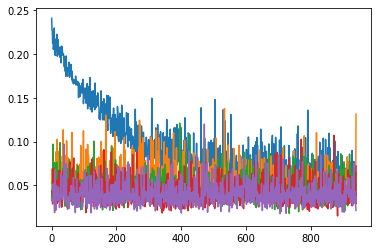

In [18]:
from matplotlib import pyplot as plt
EPOCHS = 5
model = model.cuda()
model.train()
losses = []
for epoch in range(EPOCHS):
  l = []
  for i,(x,y) in enumerate(dataloader):
    x = x.cuda()
    y = y.cuda()
    y_pred = model(x)

    optimizer.zero_grad()
    loss = criteria(y,y_pred)
    loss.backward()
    optimizer.step()
    
    l.append(loss.item())
    del x,y,y_pred
    print('Epoch:',epoch,' Batch:',i,'Batch_Loss',l[-1])
    # plt.plot(l)
  plt.plot(l)

  # plt.plot(l)
  av = np.mean(l)
  print('Epoch:',epoch,'-'*8,'Epoch_Loss:',av)
  losses.append(av)
  



In [19]:
# data = HairDataset('/content/drive/MyDrive/Train_Images/0.tif')
# np.shape(data)

Test on an image

In [20]:


x = Image.open('/content/drive/MyDrive/Test_Images/6.tif')
m = Image.open('/content/drive/MyDrive/Test_Masks/6_mask.tif')


In [21]:

t = to_tensor(x).unsqueeze(0).cuda()
model.eval()
out = model(t)

In [22]:
out_im = out.detach().cpu().squeeze().numpy()

In [23]:
out_im.shape

(1024, 1024)

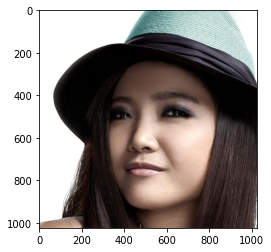

In [24]:
import matplotlib.pyplot as plt
plt.imshow(x)

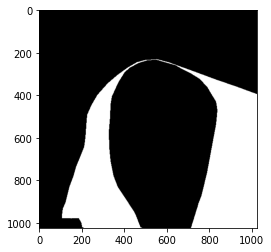

In [25]:

plt.imshow(m)

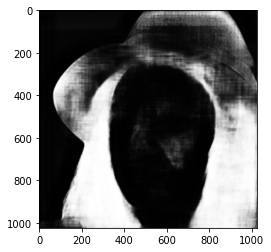

In [26]:

plt.imshow(out_im,'gray')

In [27]:

torch.save(model.state_dict(), 'model_weights.pth')

In [29]:

!pip install onnx
!pip install tensorflow
!pip install tensorflow-addons


     |████████████████████████████████| 12.3 MB 198 kB/s 
     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [75]:
!git clone https://github.com/onnx/onnx-tensorflow.git
%cd onnx-tensorflow
!pip install -e .

Cloning into 'onnx-tensorflow'...
remote: Enumerating objects: 6345, done.
remote: Counting objects: 100% (294/294), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 6345 (delta 192), reused 235 (delta 156), pack-reused 6051
Receiving objects: 100% (6345/6345), 1.97 MiB | 2.33 MiB/s, done.
Resolving deltas: 100% (4917/4917), done.
/content/onnx-tensorflow/onnx-tensorflow/onnx-tensorflow
Obtaining file:///content/onnx-tensorflow/onnx-tensorflow/onnx-tensorflow
  Attempting uninstall: onnx-tf
    Found existing installation: onnx-tf 1.9.0
    Can't uninstall 'onnx-tf'. No files were found to uninstall.
  Running setup.py develop for onnx-tf


In [31]:

!pip install onnx-tf

     |████████████████████████████████| 222 kB 5.3 MB/s 


In [32]:

import onnx
from onnx_tf.backend import prepare

In [33]:
trained_model = UNet()
trained_model.load_state_dict(torch.load('/content/model_weights.pth'))
inp = torch.autograd.Variable(torch.randn(1, 3, 1024, 1024))
torch.onnx.export(trained_model, inp, "/content/model_weights.onnx")

In [34]:
model = onnx.load('/content/model_weights.onnx')
tf_rep = prepare(model) 

In [35]:
!ls /content/*.onnx

/content/model_weights.onnx


In [37]:
img = Image.open('/content/drive/MyDrive/Train_Images/4.tif')
inp = np.asarray(img, dtype=np.float32).transpose(2,0,1)[np.newaxis, :, :, :]
out = tf_rep.run(inp)


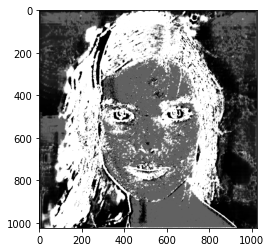

In [38]:
plt.imshow(out[0][0][0],'gray')

In [39]:
from torch.autograd import Variable

In [40]:
trained_model = UNet()
trained_model.load_state_dict(torch.load('/content/model_weights.pth'))

dummy_input = Variable(torch.randn(1, 3, 1024, 1024)) 
torch.onnx.export(trained_model, dummy_input, "/content/model_weights.onnx")

In [42]:
model = onnx.load('/content/model_weights.onnx')
tf_rep = prepare(model)

In [43]:
print('inputs:', tf_rep.inputs)

# Output nodes from the model
print('outputs:', tf_rep.outputs)

# All nodes in the model
print('tensor_dict:')
print(tf_rep.tensor_dict)

inputs: ['input.1']
outputs: ['186']
tensor_dict:
{}


In [44]:
tf_rep.export_graph('/content/drive/MyDrive/model_new1.pb')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_new1.pb/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_new1.pb/assets


In [45]:
import tensorflow as tf

In [47]:

!pip install onnx2keras

  Created wheel for onnx2keras: filename=onnx2keras-0.0.24-py3-none-any.whl size=24593 sha256=a284179003db1a808aad67fa3189267e4a5d0cae1c90c759c6fdd0f2a5d7b530
  Stored in directory: /root/.cache/pip/wheels/21/29/29/227fc9f8fed234b12169ae41f979cfadf1dcdbe1b370a5bbb5
Successfully built onnx2keras


In [49]:

import onnx
from onnx2keras import onnx_to_keras
onnx_model = onnx.load('/content/model_weights.onnx')
keras_model = onnx_to_keras(onnx_model,['input.1'])


In [50]:
keras_model.predict(inp)

array([[[[9.66724753e-01, 9.34146106e-01, 4.87758428e-01, ...,
          3.08338255e-01, 1.75081622e-02, 3.60195772e-05],
         [9.94799137e-01, 8.74145150e-01, 3.43196064e-01, ...,
          3.97873014e-01, 9.38332602e-02, 1.64795900e-04],
         [9.98244762e-01, 9.87701952e-01, 4.98084677e-03, ...,
          5.68353534e-01, 4.14244048e-02, 1.51604370e-04],
         ...,
         [1.38092309e-01, 1.27743438e-01, 7.14366883e-02, ...,
          1.87398061e-01, 1.14456572e-01, 6.86241910e-02],
         [1.79786995e-01, 9.83307138e-02, 9.68025550e-02, ...,
          2.85007596e-01, 1.01326294e-01, 8.94424468e-02],
         [1.37997895e-01, 1.37640014e-01, 9.34832320e-02, ...,
          1.59142330e-01, 8.00374150e-02, 1.12162903e-01]]]],
      dtype=float32)

In [52]:
!ls '/content/drive/MyDrive/model_new1.pb' -l

total 608
drwx------ 2 root root   4096 Oct 14 05:37 assets
-rw------- 1 root root 613910 Oct 14 05:37 saved_model.pb
drwx------ 2 root root   4096 Oct 14 05:37 variables


In [53]:
keras_model

In [61]:
keras_model.save('/content/drive/MyDrive/model_new1.pb')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_new1.pb/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_new1.pb/assets


In [62]:
model_load = tf.keras.models.load_model("/content/drive/MyDrive/model_new1.pb",compile = True)

In [57]:
tf.keras.models.save_model

<function keras.saving.save.save_model>

In [59]:
y = tf.saved_model.load('/content/drive/MyDrive/model_new_5epochs',tags=None, options=None)
print(y)


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f5f4c06d910>
